## Eli EEG gel data

Example notebook to test the data that Eli sent me on 2024-09-27 regarding his EEG gel collaboration with the group in Edmonton.

## Import libraries

In [1]:
# Common packages
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import mne
import sys

## Local packages
sys.path.append('..')
from Functions import import_data
from Functions.eeg_quality_index import EEGQualityIndex

## Magic commands
# - Interactive plots
%matplotlib qt

# - Autoreload packages
%load_ext autoreload
%autoreload 3

## Eyes open

Import data file and visualize EEG data.

In [12]:
eeg_file = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_tension_run-001_eeg.xdf'
mne_data = import_data.xdf_to_mne(eeg_file)
mne_data.plot()
channel_names = mne_data.ch_names

Creating RawArray with float64 data, n_channels=16, n_times=31488
    Range : 0 ... 31487 =      0.000 ...   122.996 secs
Ready.


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 sec)



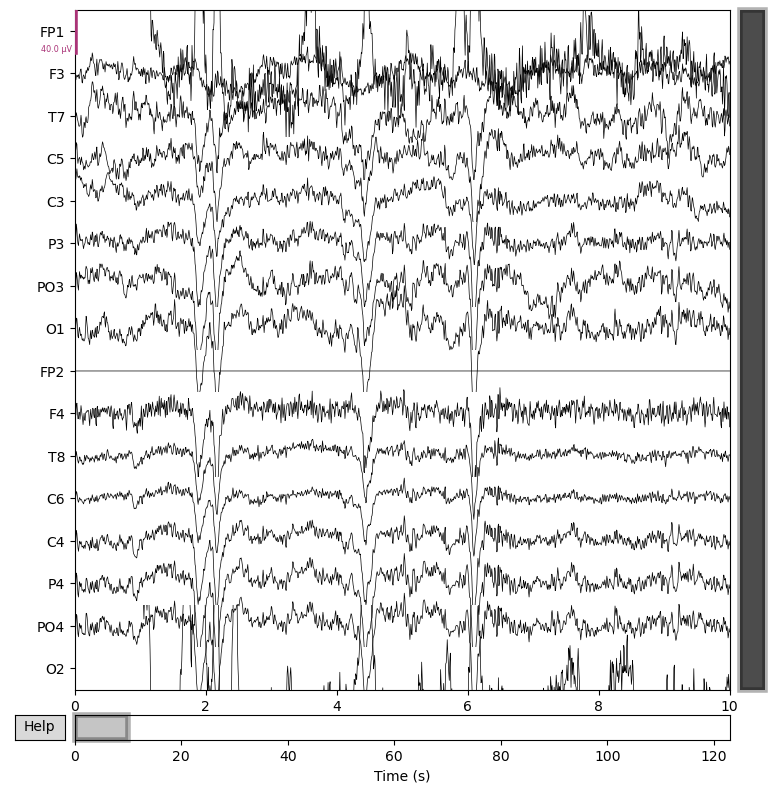

In [15]:
#Rereference the EEG to FP2, as that was where the reference was placed
mne_data.set_eeg_reference(ref_channels=['FP2'])

#Clean the data to have a clean epoch before the EEG quality index is calculated

#bandpass
mne_data.filter(l_freq=0.5, h_freq=40)

#plot the data again with appropriate bounds
mne_data.plot()

Extract EEG data and compute EEG quality index

In [16]:
test_eeg = mne_data.copy().pick_channels(["FP1", "F4"], True).get_data()[0][np.newaxis,:]

In [19]:
## EEG quality index settings
test_chans = ["FP1", "F4"]
clean_eeg = mne_data.copy().pick_channels(["F4"]).get_data()[0][np.newaxis,:]
test_eeg = mne_data.copy().pick_channels(test_chans, True).get_data()[0]
srate = mne_data.info['sfreq']
sliding = True                  # Sliding window flag
slide_window = int(1 * srate)   # Sliding window size [sec * samples = samples]
slide_step = int(0.5 * srate)   # Sliding window step [sec * samples = samples]            

## Create EEG quality index object
eeg_quality = EEGQualityIndex(
    clean_eeg,
    test_eeg,
    srate,
    sliding = sliding,
    window = slide_window,
    slide = slide_step
    )

## Compute EEG quality index scores
eqi_scores = eeg_quality.compute_zscores()

ValueError: test_eeg must be a 2D array

Visualize EEG quality index

In [6]:
eeg_quality.heatmap(
    chans = test_chans
)

ValueError: Shape of passed values is (6, 2), indices imply (6, 3)

In [4]:
eeg_eyes_open = pyxdf.load_xdf(r'..\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_tension_run-001_eeg.xdf')

In [ ]:
eeg_eyes_open = 

In [ ]:
eeg_stream.keys()

In [ ]:
eeg_stream['info']['desc'][0]['channels'][0]